In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
import matplotlib as mpl
import spacy
mpl.rcParams['axes.linewidth'] = 3

In [3]:
#word vector model used to filter recipes by ingredient similarity
nlp = spacy.load('/tmp/recipe_vector_lg')

In [3]:
recipedb = pd.read_csv('recipe_nutrition_app/app_data/allrecipes_nutr_labels.csv').set_index('recipename')
ingreddb = pd.read_csv('recipe_nutrition_app/app_data/ingreds_db_cleaned.csv').rename(columns={'Unnamed: 0':'recipename'})
ingreddb = ingreddb.set_index('recipename')

In [254]:
#simulate changes in health score, nutrient levels, and ingredient similarity for a user who changes 
#choice 20,40,60,80,100% of time to the best class 
#constrained to choices that are initially in classes 2 and 3
numiter = 1000
label_ranks = np.array([2,3,1,0])
similar_choice = []
better_choice = []
best_choice = []
while len(best_choice) < numiter:
    randind = np.random.randint(0,len(recipedb)-1)
    first = recipedb.iloc[randind]
    firstname = recipedb.iloc[randind].name
    firstlabel = recipedb.iloc[randind].labels
    targetingred = nlp(ingreddb.loc[firstname].ingredients)
    firstlabelind = np.where(label_ranks==firstlabel)[0][0]
    betterlabels = label_ranks[firstlabelind:]
    if len(betterlabels) < 3:
        continue
    
    similar_alts = recipedb[(recipedb.labels == betterlabels[0]) & (recipedb.class_prob >= 0.85)].index
    similarity = []
    for num in range(0,len(similar_alts)):
            similarity.append(targetingred.similarity(nlp(ingreddb.loc[similar_alts[num]].ingredients)))
    similarity = np.array(similarity)
    similarity = similarity[(-similarity).argsort()[:10]]
    similar_alts = similar_alts[(-similarity).argsort()[:10]]
    similar_recipes = recipedb.loc[similar_alts]
    similar_recipes['ingred_similarity'] = similarity
        
    best_alts = recipedb[(recipedb.labels==betterlabels[2]) & (recipedb.class_prob >= 0.85)].index
    similarity = []
    for num in range(0,len(best_alts)):
            similarity.append(targetingred.similarity(nlp(ingreddb.loc[best_alts[num]].ingredients)))
    similarity = np.array(similarity)
    similarity = similarity[(-similarity).argsort()[:10]]
    best_alts = best_alts[(-similarity).argsort()[:10]]
    best_recipes = recipedb.loc[best_alts]
    best_recipes['ingred_similarity'] = similarity
    
    similar_choice.append(similar_recipes.iloc[[np.random.randint(0,9)]])
    best_choice.append(best_recipes.iloc[[0]])
similar_vs_best_choice = pd.concat(similar_choice)
best_choice = pd.concat(best_choice)

In [255]:
#simulate changes in health score, nutrient levels, and ingredient similarity for a user who changes 
#choice 20,40,60,80,100% of time to the better class 
#constrained to choices that are initially in classes 2,3,and 1
label_ranks = np.array([2,3,1,0])
similar_choice = []
better_choice = []
while len(better_choice) < numiter:
    randind = np.random.randint(0,len(recipedb)-1)
    first = recipedb.iloc[randind]
    firstname = recipedb.iloc[randind].name
    firstlabel = recipedb.iloc[randind].labels
    targetingred = nlp(ingreddb.loc[firstname].ingredients)
    firstlabelind = np.where(label_ranks==firstlabel)[0][0]
    betterlabels = label_ranks[firstlabelind:]
    if len(betterlabels) < 2:
        continue
    
    similar_alts = recipedb[(recipedb.labels == betterlabels[0]) & (recipedb.class_prob >= 0.85)].index
    similarity = []
    for num in range(0,len(similar_alts)):
            similarity.append(targetingred.similarity(nlp(ingreddb.loc[similar_alts[num]].ingredients)))
    similarity = np.array(similarity)
    similarity = similarity[(-similarity).argsort()[:10]]
    similar_alts = similar_alts[(-similarity).argsort()[:10]]
    similar_recipes = recipedb.loc[similar_alts]
    similar_recipes['ingred_similarity'] = similarity
        
    better_alts = recipedb[(recipedb.labels==betterlabels[1]) & (recipedb.class_prob >= 0.85)].index
    similarity = []
    for num in range(0,len(better_alts)):
            similarity.append(targetingred.similarity(nlp(ingreddb.loc[better_alts[num]].ingredients)))
    similarity = np.array(similarity)
    similarity = similarity[(-similarity).argsort()[:10]]
    better_alts = better_alts[(-similarity).argsort()[:10]]
    better_recipes = recipedb.loc[better_alts]
    better_recipes['ingred_similarity'] = similarity
    
    similar_choice.append(similar_recipes.iloc[[np.random.randint(0,9)]])
    better_choice.append(better_recipes.iloc[[0]])
similar_vs_better_choice = pd.concat(similar_choice)
better_choice = pd.concat(better_choice)

In [278]:
#make table for similar vs best choices with range in choice percent: 0,20,40,60,80,100

choices = []
similar_vs_best_choice['choice'] ='similar'
similar_vs_best_choice['choice_percent'] = 0
choices.append(similar_vs_best_choice)
for num in [20,40,60,80,100]:
    randsample = np.random.choice(range(0,1000),size=1000,replace=False)
    best_choice_sample = pd.concat([similar_vs_best_choice.iloc[randsample[:(1000-num*10)]],
                                    best_choice.iloc[randsample[-(num*10):]]])
    best_choice_sample['choice'] = 'best'
    best_choice_sample['choice_percent'] = num
    choices.append(best_choice_sample)
choices = pd.concat(choices,sort=False)
choices.to_csv('validation_bestchoices.csv')

/home/jcheung2009/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [279]:
#make table for similar vs better choices with range in choice percent: 0,20,40,60,80,100

choices = []
similar_vs_better_choice['choice'] ='similar'
similar_vs_better_choice['choice_percent'] = 0
choices.append(similar_vs_best_choice)
for num in [20,40,60,80,100]:
    randsample = np.random.choice(range(0,1000),size=1000,replace=False)
    better_choice_sample = pd.concat([similar_vs_better_choice.iloc[randsample[:(1000-num*10)]],
                                    better_choice.iloc[randsample[-(num*10):]]])
    better_choice_sample['choice'] = 'better'
    better_choice_sample['choice_percent'] = num
    choices.append(better_choice_sample)
choices = pd.concat(choices,sort=False)
choices.to_csv('validation_betterchoices.csv')

/home/jcheung2009/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



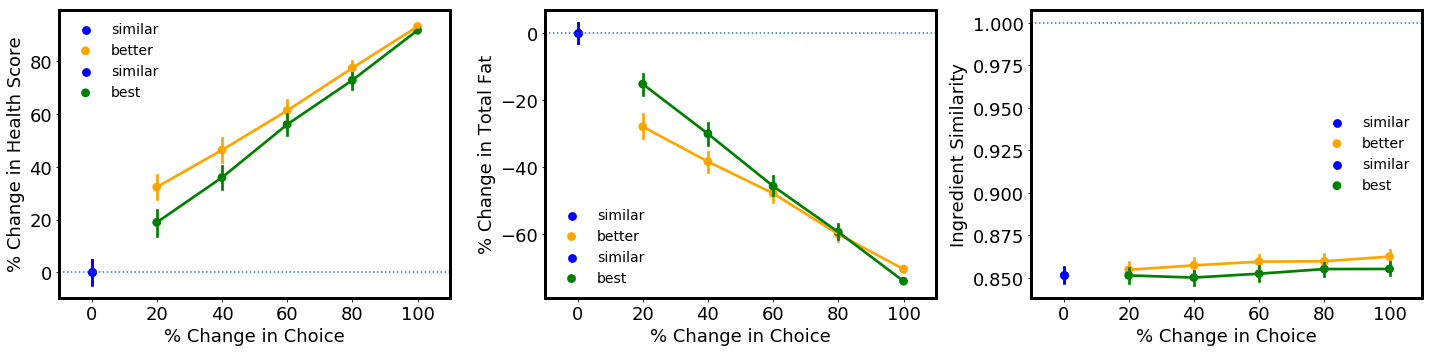

In [296]:
# #normalize by mean of 100% similar choice to get percent change
betterchoices = pd.read_csv('validation_betterchoices.csv').set_index('recipename')
betterchoices['Health Score'] = 100*(betterchoices['Health Score']-betterchoices.loc[(betterchoices['choice']=='similar') &
            (betterchoices['choice_percent']==0),'Health Score'].mean())/abs(betterchoices.loc[(betterchoices['choice']=='similar') &
                (betterchoices['choice_percent']==0),'Health Score'].mean())
betterchoices['Total Fat'] = 100*(betterchoices['Total Fat']-betterchoices.loc[(betterchoices['choice']=='similar') &
            (betterchoices['choice_percent']==0),'Total Fat'].mean())/abs(betterchoices.loc[(choices['choice']=='similar') &
                (betterchoices['choice_percent']==0),'Total Fat'].mean())

bestchoices = pd.read_csv('validation_bestchoices.csv').set_index('recipename')
bestchoices['Health Score'] = 100*(bestchoices['Health Score']-bestchoices.loc[(bestchoices['choice']=='similar') &
            (bestchoices['choice_percent']==0),'Health Score'].mean())/abs(bestchoices.loc[(bestchoices['choice']=='similar') &
                (bestchoices['choice_percent']==0),'Health Score'].mean())
bestchoices['Total Fat'] = 100*(bestchoices['Total Fat']-bestchoices.loc[(bestchoices['choice']=='similar') &
            (bestchoices['choice_percent']==0),'Total Fat'].mean())/abs(bestchoices.loc[(bestchoices['choice']=='similar') &
                (bestchoices['choice_percent']==0),'Total Fat'].mean())


plt.figure(figsize=(20,5))
ax = plt.subplot(131)
sns.pointplot(x="choice_percent",y="Health Score",hue="choice",data=betterchoices,palette=['b','orange'])
sns.pointplot(x="choice_percent",y="Health Score",hue="choice",data=bestchoices,palette=['b','g'])
plt.ylabel('% Change in Health Score',fontsize=18)
plt.xlabel('% Change in Choice',fontsize=18)
ax.axhline(0,ls=':')
ax.tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=14)

ax = plt.subplot(132)
sns.pointplot(x="choice_percent",y="Total Fat",hue="choice",data=betterchoices,palette=['b','orange'])
sns.pointplot(x="choice_percent",y="Total Fat",hue="choice",data=bestchoices,palette=['b','g'])
plt.ylabel('% Change in Total Fat',fontsize=18)
plt.xlabel('% Change in Choice',fontsize=18)
ax.axhline(0,ls=':')
ax.tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=14)

ax = plt.subplot(133)
sns.pointplot(x="choice_percent",y="ingred_similarity",hue="choice",data=betterchoices,palette=['b','orange'])
sns.pointplot(x="choice_percent",y="ingred_similarity",hue="choice",data=bestchoices,palette=['b','g'])
plt.ylabel('Ingredient Similarity',fontsize=18)
plt.xlabel('% Change in Choice',fontsize=18)
ax.axhline(1,ls=':')
ax.tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=14)

plt.tight_layout()

plt.savefig('validation.png',dpi=300)